In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class LSTM_Node(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_Node, self).__init__()
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.cell_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, h, c):
        x_h = torch.cat((x, h), 1)
        f = torch.sigmoid(self.forget_gate(x_h))
        i = torch.sigmoid(self.input_gate(x_h))
        c_tilde = torch.tanh(self.cell_gate(x_h))
        c_new = f * c + i * c_tilde
        o = torch.sigmoid(self.output_gate(x_h))
        h_new = o * torch.tanh(c_new)
        return h_new, c_new
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.nodes = nn.ModuleList([LSTM_Node(input_size, hidden_size) if i == 0 else LSTM_Node(hidden_size, hidden_size) for i in range(num_layers)])

    def forward(self, x, state):
        batch_size, sequence_length, input_size = x.shape   
        h, c = state
        outputs = []
        if self.num_layers == 1:
            h=h.squeeze(0)
            c=c.squeeze(0)
            for i in range(sequence_length):
                h, c = self.nodes[0](x[:, i, :], h, c)
                outputs.append(h)
            output = torch.stack(outputs, 1), (h, c)
        else:
            for i in range(self.num_layers): # Stacked LSTMs' TODO: fix problem with inplace edits of gradient variables
                for j in range(sequence_length):
                    h[i], c[i] = self.nodes[i](x[:, j, :], h[i], c[i])
                    outputs.append(h)
        return torch.stack(outputs, 1), (h, c)

        

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM_Network(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_Network, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = LSTM(input_size, hidden_size, num_layers) # this can be switched out with nn.LSTM to see that implementation is correct
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, sequence_length, input_size):
        assert x.shape == (x.shape[0], sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)

        lstm_out, _ = self.lstm(x, (h0, c0))
        out = self.fc(lstm_out[:, -1, :])

        return out


def train_model(model, train_loader, epochs, optimizer, loss_function, sequence_length, input_size,val_loader, verbose=False,save_model=False):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            model.zero_grad()
            output = model(x, sequence_length, input_size)
            y = y.view(-1, 1) #TODO: make sure size is 32,1
            loss = loss_function(output, y)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if verbose and i % (train_loader.batch_size*10) == 0:
                print(
                    f'Epoch {epoch} Batch {i//train_loader.batch_size} loss: {loss.item()}')
        print(f'Epoch {epoch} loss: {np.mean(epoch_losses)}, val_loss: {validate(model, val_loader)}')
        losses.append(epoch_losses)
    if save_model:
        torch.save(model.state_dict(), 'trained_models/lstm_trained_model.pth')
    return losses

def validate(network, val_loader):
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            network.eval()
            o = network(features.to(device), features.shape[1], features.shape[2])
            loss = torch.nn.functional.mse_loss(o, labels.to(device))
            losses.append(loss.item())
    losses = np.array(losses)
    losses = losses[~np.isnan(losses)]
    return np.mean(losses)


In [3]:
from load_data import getTrainingSet, getValidationSet
from config import *
dataset = getTrainingSet(reshape=False)
val_set = getValidationSet()
input_size = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
hidden_size = LSTM_SIZE_OF_HIDDEN_LAYER
num_layers = LSTM_NUM_LAYERS
output_size = OUTPUT_SIZE
learning_rate = LEARNING_RATE
l2_r_rate = L2_REGULARIZATION_RATE
batch_size = BATCH_SIZE
epochs = LSTM_EPOCHS

print(f'input_size: {input_size}, sequence_length: {sequence_length}')

model = LSTM_Network(input_size, hidden_size, num_layers, output_size)
loss_function = nn.MSELoss()
adam = optim.Adam(model.parameters(), learning_rate, weight_decay=l2_r_rate)
train_dataloader = DataLoader(dataset, batch_size, shuffle=False)

input_size: 6, sequence_length: 24


In [4]:
losses = train_model(
    model,
    train_dataloader,
    epochs,
    adam,
    loss_function,
    sequence_length,
    input_size,
    val_loader=DataLoader(val_set, batch_size, shuffle=False),
    save_model=True
)

C:\Users\Jonah\AppData\Local\Temp\ipykernel_5300\2205952794.py:54: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(o, labels.to(device))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_5300\2205952794.py:54: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(o, labels.to(device))


Epoch 0 loss: 0.054139281886487006, val_loss: 1.5241572584191414
Epoch 1 loss: 0.01695566601353616, val_loss: 1.6246772565253793
Epoch 2 loss: 0.010854634581780381, val_loss: 1.655052936567019
Epoch 3 loss: 0.008861510675459127, val_loss: 1.6927703863953891
Epoch 4 loss: 0.008038309261705862, val_loss: 1.700981897034057
Epoch 5 loss: 0.007774894290079403, val_loss: 1.7016458756303134
Epoch 6 loss: 0.007511872813924739, val_loss: 1.7086335059714644
Epoch 7 loss: 0.0072496566377846985, val_loss: 1.7075011790615238
Epoch 8 loss: 0.0070102926467742474, val_loss: 1.7190490954542814
Epoch 9 loss: 0.006792041043490495, val_loss: 1.714583205850157


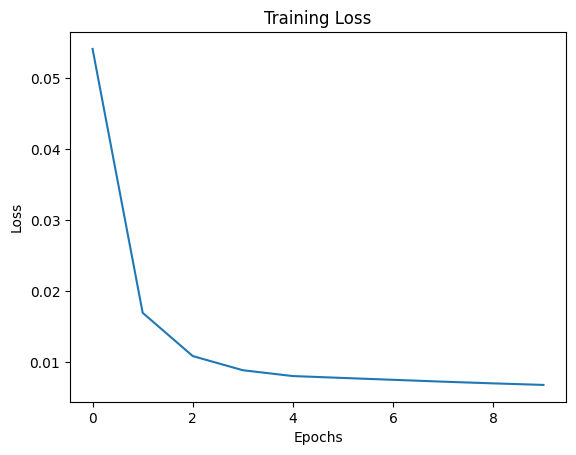

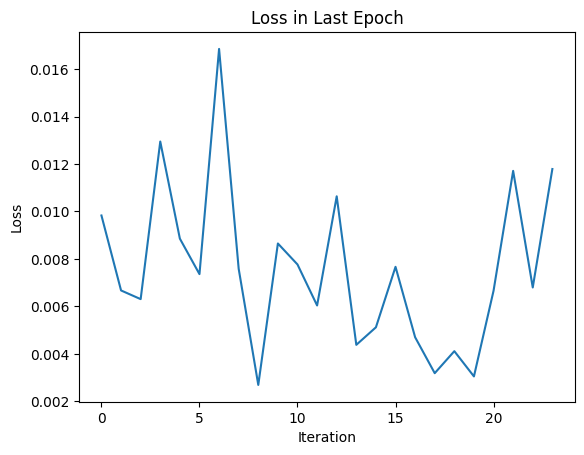

In [5]:
plt.plot([sum(epoch_losses)/len(epoch_losses) for epoch_losses in losses])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(losses[-1][:24])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss in Last Epoch')
plt.show()


In [4]:
from load_data import getTestData
model.load_state_dict(torch.load('trained_models/lstm_trained_model.pth'))

model.eval()

data = getTestData()
y_scaler = data[2]
data = (data[0].astype(np.float32), data[1])

In [5]:
import random
def plot_predictions(predictions, targets, y_scaler,axs):
    predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    targets = y_scaler.inverse_transform(targets.reshape(-1, 1))
    axs.plot([i for i in range(24,48)], predictions, label='Predictions')
    
    axs.plot(targets[0:48], label='Targets')
    axs.legend()

def predict_one_horizon(model, X_test, given_cases,forecast_horizon):
    X_test = X_test.copy()
    predictions = []
    assert len(X_test) == forecast_horizon+given_cases
    with torch.no_grad():
        for i in range(forecast_horizon):
            x = torch.tensor(X_test[i:i+forecast_horizon]).to(device)
            x = x.view(1,forecast_horizon,input_size)
            output = model.forward(x,sequence_length=forecast_horizon,input_size=input_size)
            predictions.append(output.item())
            X_test[i+forecast_horizon][-1] = output.item()
    return predictions

def average_error_over_horizons(model, X_test, y_test, forecast_horizon,y_scaler,random_samples=5):
    random.seed(42)
    random_numbers = random.sample(range(len(X_test)-2*forecast_horizon), random_samples)
    fig, axs = plt.subplots(len(random_numbers)+1, figsize=(10, 5*(len(random_numbers)+1)))
    errors_in_horizon = []
    j=0
    for i in range(len(X_test)-2*forecast_horizon):
        preds = predict_one_horizon(model, X_test[i:i+2*forecast_horizon], given_cases=forecast_horizon, forecast_horizon=forecast_horizon)
        if i in random_numbers:
            plot_predictions(preds, y_test[i:i+2*forecast_horizon], y_scaler,axs[j])
            j+=1
                
        error_t =preds-y_test[i+forecast_horizon-1:i+2*forecast_horizon-1]
        error_t = np.square(error_t)
        errors_in_horizon.append(error_t)
        if i % ((len(X_test)-2*forecast_horizon)//10) == 0:
            print(f'{np.round(i*100/(len(X_test)-2*forecast_horizon),-1)}% done',end='\r')

    error_plot = np.mean(errors_in_horizon, axis=0)
    axs[-1].plot( error_plot)
    axs[-1].set_title('Mean squared error over the horizon')
    axs[-1].set_xlabel('Horizon')
    axs[-1].set_ylabel('MSE')
    plt.tight_layout()
    plt.show()
    return np.mean(errors_in_horizon)

[]

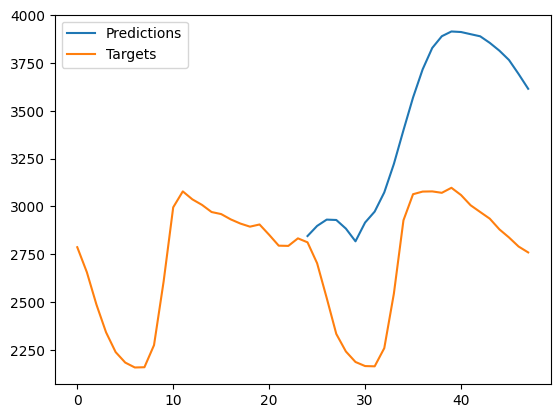

In [6]:
preds=predict_one_horizon(model, data[0][:48], 24, 24)
plot_predictions(preds, data[1], y_scaler,plt)
plt.plot()

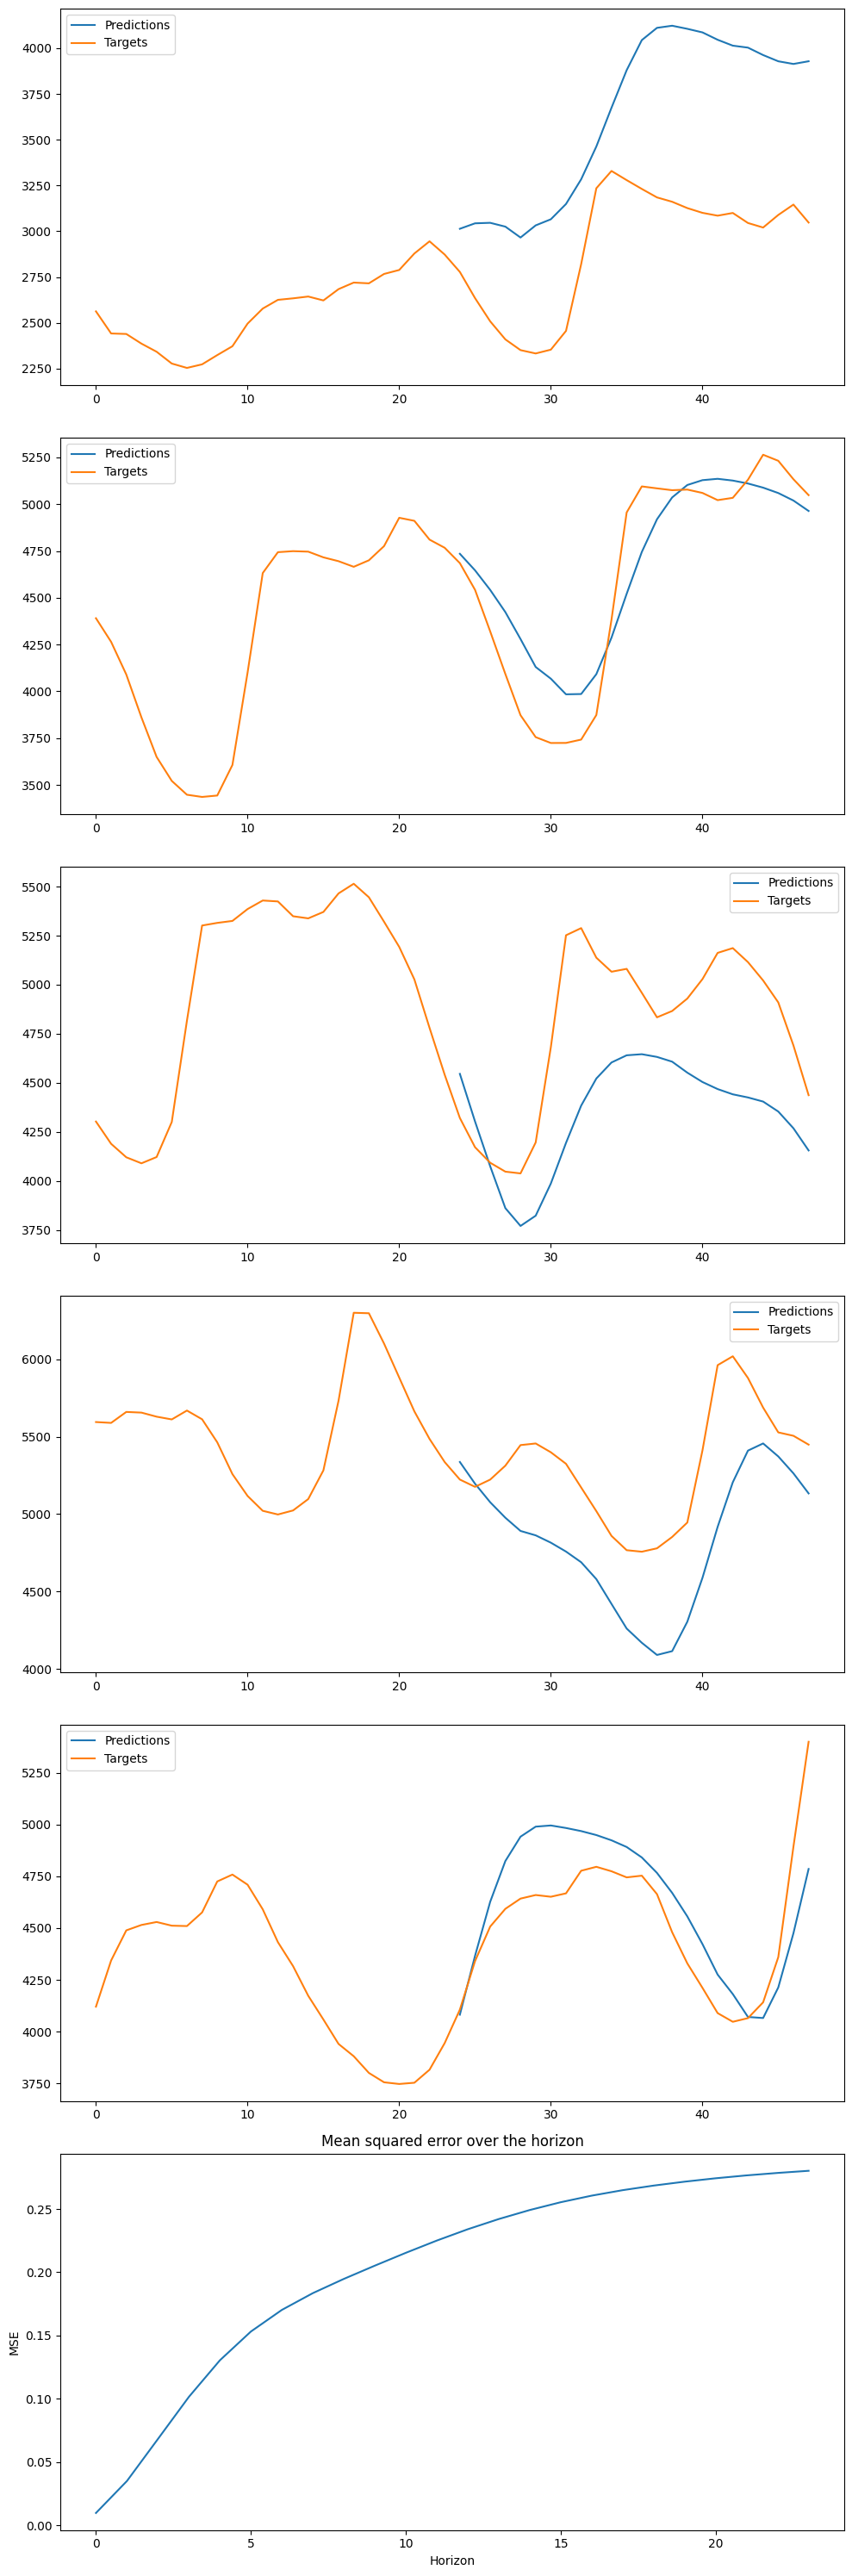

Average error over horizons area NO1: 0.2020276756794601


In [7]:
from load_data import add_entry_to_results
# Avg error over no1
avg_no1 = average_error_over_horizons(model, data[0], data[1], 24, y_scaler, random_samples=5)
print(f'Average error over horizons area NO1: {avg_no1}')
add_entry_to_results('lstm_no1', avg_no1,'testset_results.csv')

KeyboardInterrupt: 

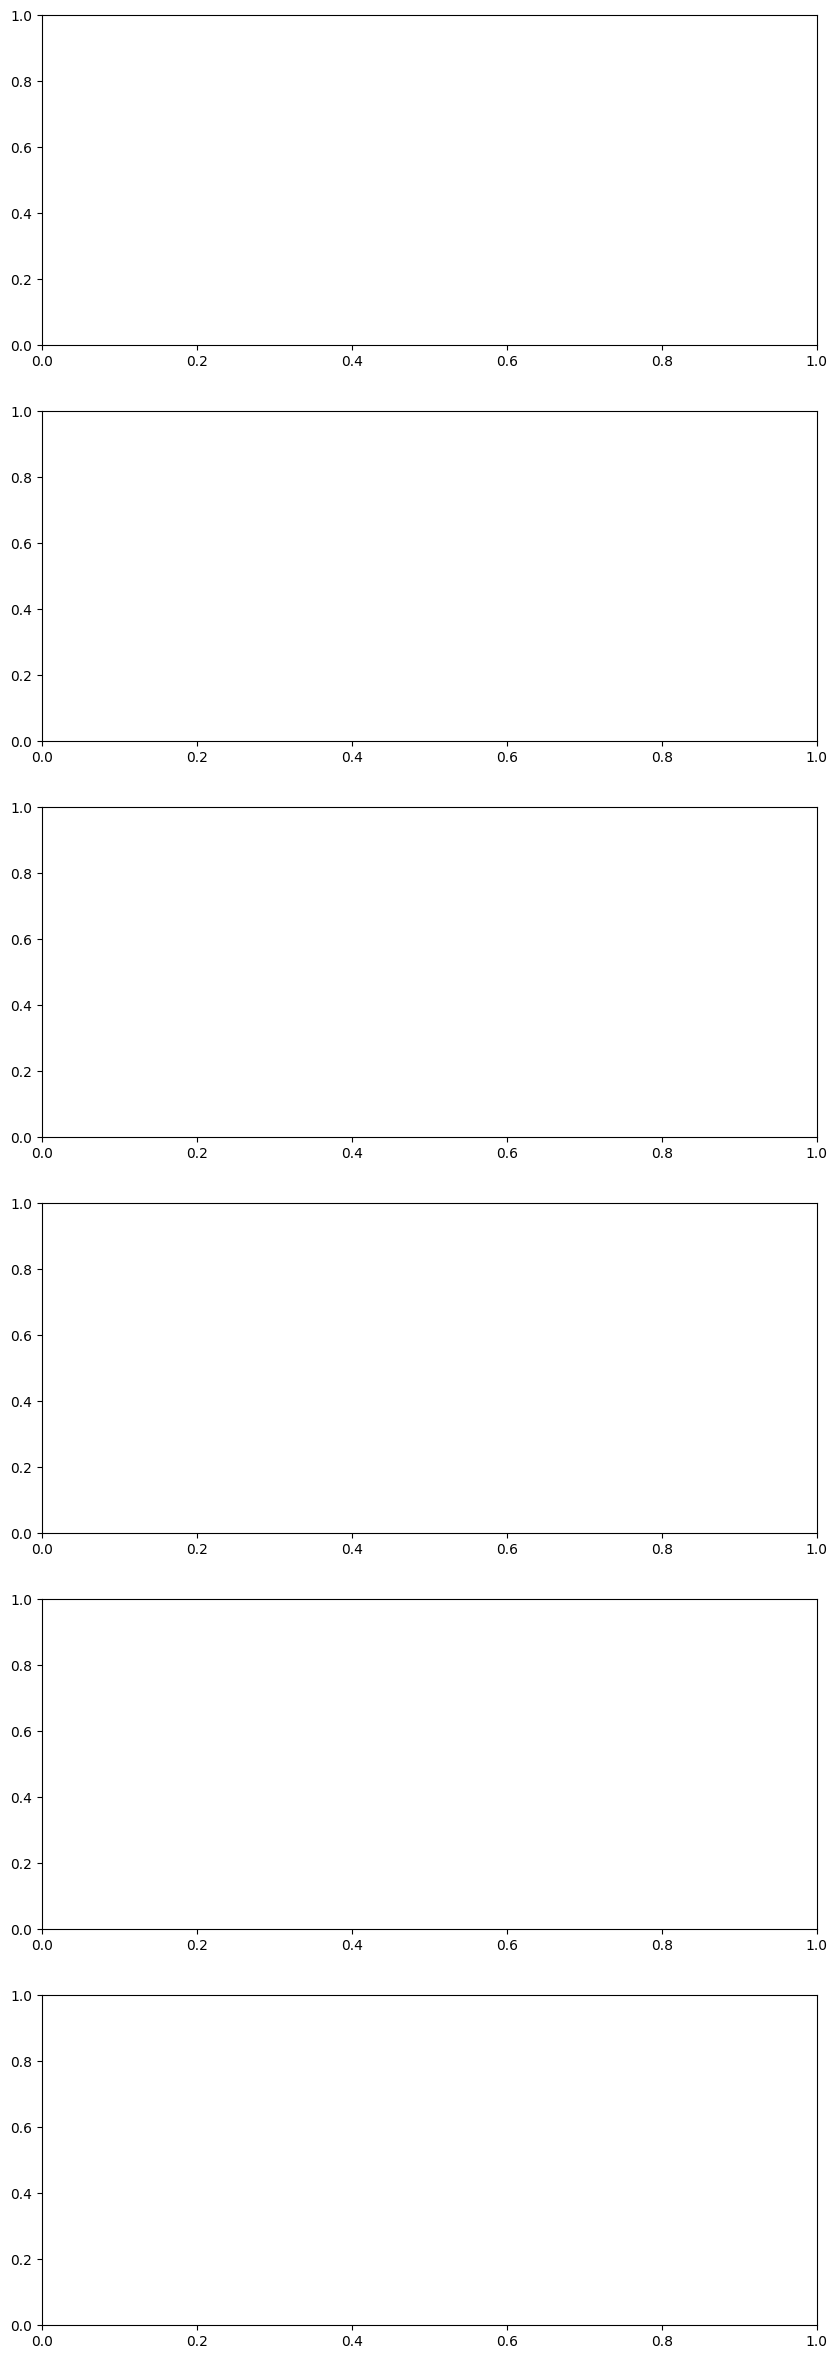

In [27]:
from load_data import getTestData
model.load_state_dict(torch.load('trained_models/lstm_trained_model.pth'))

model.eval()

data = getTestData(region=3)
y_scaler = data[2]
data = (data[0].astype(np.float32), data[1])

# Avg error over no3
avg_no3 =average_error_over_horizons(model, data[0], data[1], 24,y_scaler)
print(avg_no3)

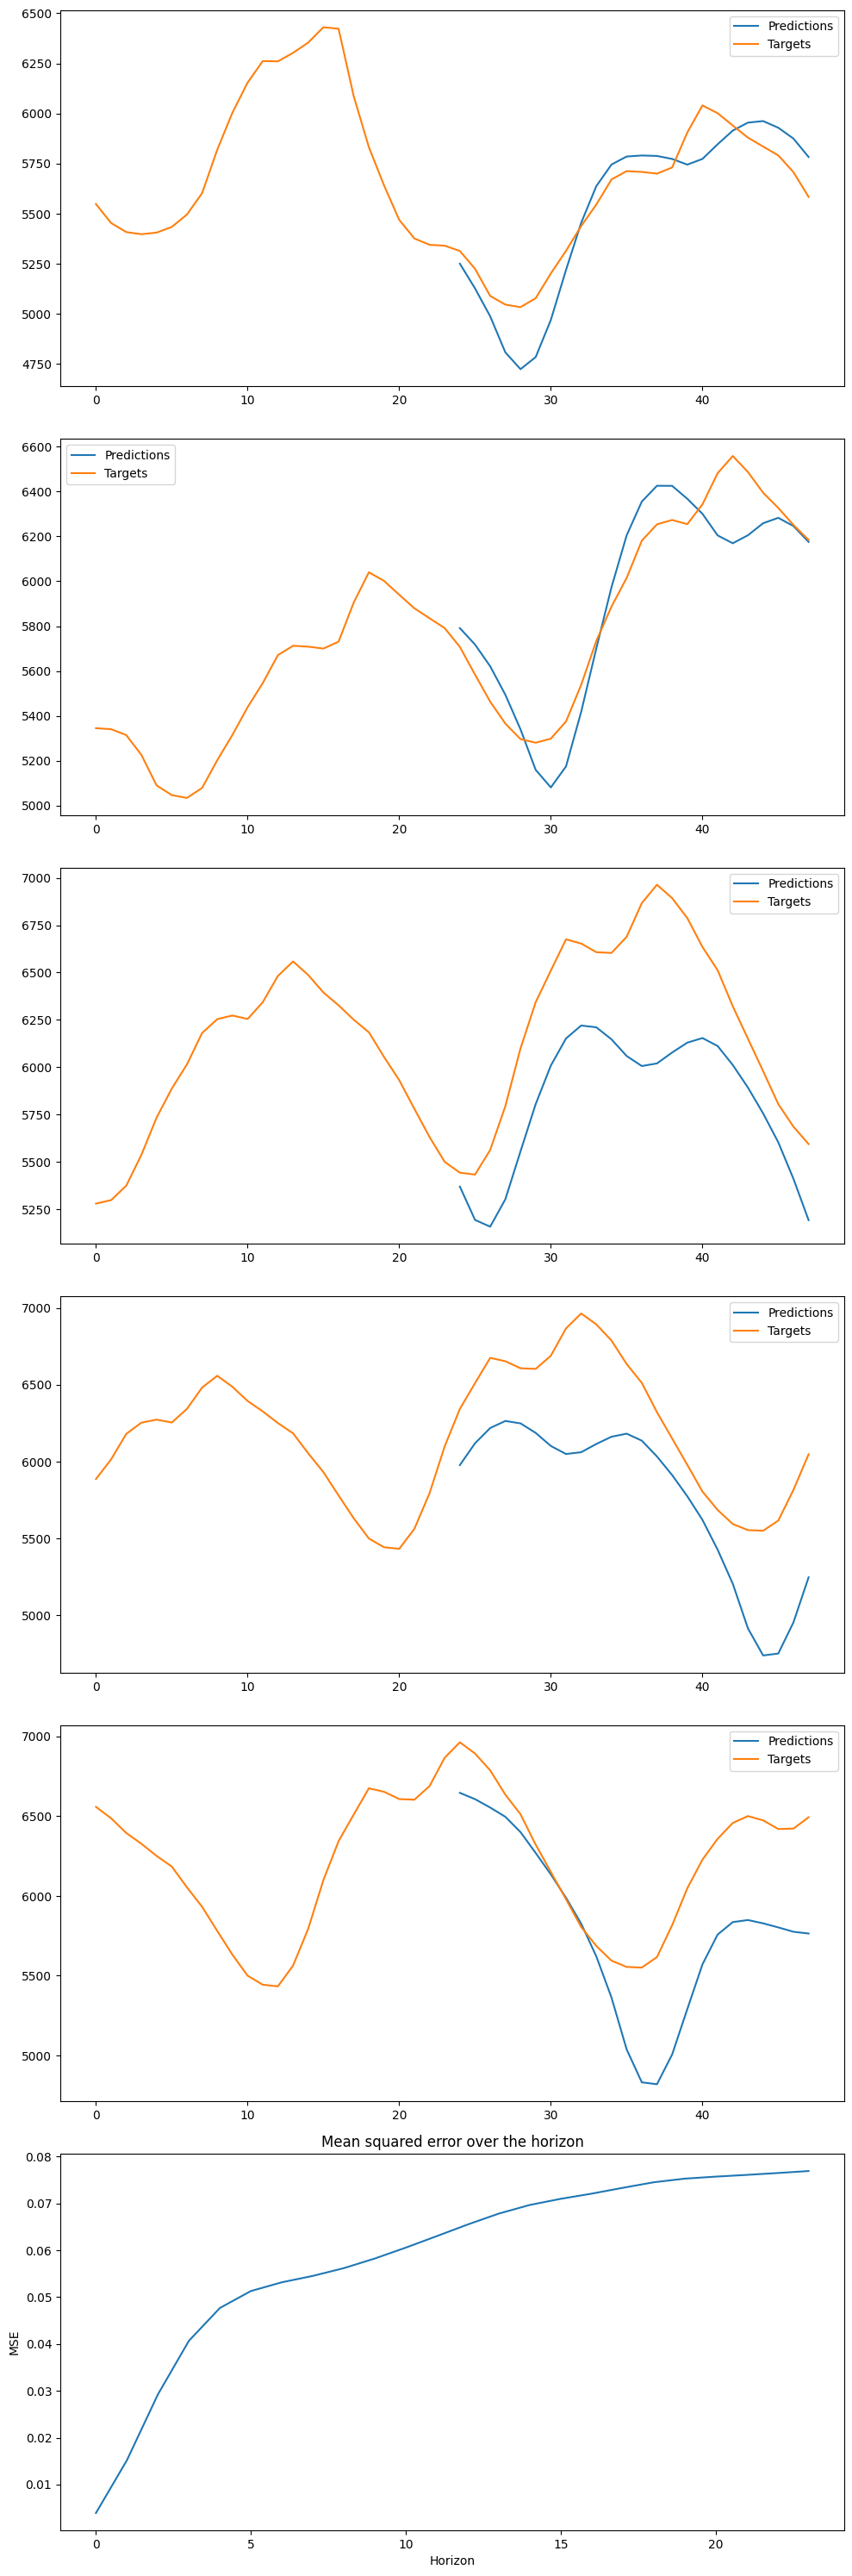

0.05868219825301882


In [30]:
from load_data import createTestDataFromHoldOut,add_entry_to_results
model.load_state_dict(torch.load('trained_models/lstm_trained_model.pth'))

model.eval()

data = createTestDataFromHoldOut(filepath='holdout.csv',region=1)
y_scaler = data[2]
data = (data[0].astype(np.float32), data[1])

# Avg error over no1 holdout
avg_holdout = average_error_over_horizons(model, data[0], data[1], 24,y_scaler)
print(avg_holdout)
add_entry_to_results('LSTM_no1_holdout',avg_holdout,'houldout_results.csv')